In [2]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches

In [3]:
N = 100 
t = 3 
b = 0.95

In [4]:
def cdf_inverse(Fx, theta = t):
    return ((-Fx+1) ** (-1/(theta-1))).astype(float)

def generate_sample(n = N, theta = t, random_state = None):
    if random_state is not None:
        np.random.seed(random_state)
    Fx = np.random.sample(n)
    return cdf_inverse(Fx, theta)

sample = generate_sample(random_state = 42)
sample

array([1.26444595, 4.50442711, 1.93164669, 1.57849408, 1.08851288,
       1.08849733, 1.03037147, 2.73358909, 1.58334718, 1.85081305,
       1.01045392, 5.76484771, 2.44297063, 1.12675725, 1.10554618,
       1.10661489, 1.1988669 , 1.45058064, 1.32679802, 1.18781026,
       1.605099  , 1.07801056, 1.18857814, 1.25625944, 1.35590258,
       2.15753854, 1.11780611, 1.43478438, 1.56635672, 1.02406697,
       1.59626498, 1.09798933, 1.03420391, 4.42311366, 5.39415075,
       2.2845425 , 1.19918712, 1.05273197, 1.77957644, 1.33648819,
       1.06724026, 1.40744164, 1.01765083, 3.32081901, 1.1615193 ,
       1.72138276, 1.20535399, 1.44347795, 1.48529276, 1.10759866,
       5.7339438 , 2.10880764, 4.06554258, 3.08353294, 1.57700457,
       3.57769125, 1.04741762, 1.11523746, 1.02341081, 1.21745917,
       1.27898289, 1.17149443, 2.41640025, 1.24684143, 1.17927686,
       1.47875947, 1.07890763, 2.24845159, 1.03949803, 8.73268751,
       2.0953946 , 1.11713762, 1.00277255, 2.32785767, 1.84697

In [5]:
def calc_quantiles(beta):
    erfinv = sp.special.erfinv
    u1 = 2**0.5 * erfinv(-beta)
    u2 = -u1
    return u1, u2

def median_asymptotic_confidence_interval(sample, beta = b, precision = 3):
    n = np.size(sample)
    theta_est = n / np.sum(np.log(sample)) + 1
    u1, u2 = calc_quantiles(beta)
    t1 = (u1 * 2**(1/(theta_est-1)) * np.log(2)) / ((theta_est-1) * n**0.5) + 2**(1/(theta_est-1))
    t2 = (u2 * 2**(1/(theta_est-1)) * np.log(2)) / ((theta_est-1) * n**0.5) + 2**(1/(theta_est-1))
    return round(t1, precision), round(t2, precision)

t1, t2 = median_asymptotic_confidence_interval(sample)
print(f'Асимптотический доверительный интервал для медианы = ({t1}, {t2})')
print(f'Реальная медиана = {round(np.median(sample), 3)}')

Асимптотический доверительный интервал для медианы = (1.288, 1.458)
Реальная медиана = 1.366


In [6]:
def asymptotic_confidence_interval_omm(sample, beta = b, precision = 3):
    n = np.size(sample)
    a1 = np.mean(sample)
    a2 = np.dot(sample, sample) / n 
    u1, u2 = calc_quantiles(beta)
    t1 = (u1 * (a2-a1**2)**0.5 / ((a1-1)**2 * n**0.5)) + 2 + 1/(a1-1)
    t2 = (u2 * (a2-a1**2)**0.5 / ((a1-1)**2 * n**0.5)) + 2 + 1/(a1-1)
    return round(t1, precision), round(t2, precision)

def asymptotic_confidence_interval_omp(sample, beta = b, precision = 3):
    n = np.size(sample)
    theta_est = n / np.sum(np.log(sample)) + 1
    u1, u2 = calc_quantiles(beta)
    t1 = u1 * (theta_est-1)/(n**0.5) + theta_est
    t2 = u2 * (theta_est-1)/(n**0.5) + theta_est
    return round(t1, precision), round(t2, precision)

t1_omm, t2_omm = asymptotic_confidence_interval_omm(sample)
print(f'Асимптотический доверительный интервал (OMM) = ({t1_omm}, {t2_omm})')
t1_omp, t2_omp = asymptotic_confidence_interval_omp(sample)
print(f'Асимптотический доверительный интервал (OMП) = ({t1_omp}, {t2_omp}) - нельзя использовать')

intervals = []
intervals.extend([(t1_omm, t2_omm), (t1_omp, t2_omp)])

Асимптотический доверительный интервал (OMM) = (2.876, 3.616)
Асимптотический доверительный интервал (OMП) = (2.758, 3.615) - нельзя использовать


In [7]:
def est_1(sample): # OMП
    n = np.size(sample)
    return 1 + n/(np.sum(np.log(sample))) 

def est_2(sample): # OMM
    return 2 + 1/(np.mean(sample) - 1)

n_est = np.array([est_1, est_2])

print(f'Оценки: {"; ".join([f"тета_{i+1}={round(est(sample), 3)}" for i, est in enumerate(n_est)])}')

Оценки: тета_1=3.186; тета_2=3.246


In [8]:
def bootstrap_confidence_interval(sample, estimation, beta = b, BOOTSTRAP_RANGE = 1000, precision = 3):
    theta_est = estimation(sample)
    deltas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = np.random.choice(sample, size=np.size(sample))
        deltas.append(estimation(sample_i) - theta_est)
    k1 = int((1-beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1+beta)/2 * BOOTSTRAP_RANGE) - 1
    deltas = np.sort(deltas)
    t1 = -deltas[k2] + theta_est
    t2 = -deltas[k1] + theta_est
    return round(t1, precision), round(t2, precision)

intervals_ = [bootstrap_confidence_interval(sample, est_1), bootstrap_confidence_interval(sample, est_2)]
print('Bootstrap доверительные интервалы:')
print('тета_1 =', intervals_[0], end='\n')
print('тета_2 =', intervals_[1], end='\n')
intervals.extend(intervals_)

Bootstrap доверительные интервалы:
тета_1 = (2.688, 3.54)
тета_2 = (2.748, 3.554)


In [9]:
def bootstrap_with_parameter_confidence_interval(sample, estimation, beta = b, BOOTSTRAP_RANGE = 10_000, precision = 3):
    theta_est = estimation(sample)
    thetas = []
    for i in range(BOOTSTRAP_RANGE):
        sample_i = generate_sample(theta=theta_est)
        thetas.append(estimation(sample_i))
    thetas = np.sort(thetas)
    k1 = int((1-beta)/2 * BOOTSTRAP_RANGE) - 1
    k2 = int((1+beta)/2 * BOOTSTRAP_RANGE) - 1
    t1 = thetas[k1]
    t2 = thetas[k2]
    return round(t1, precision), round(t2, precision)
    
intervals_ = [bootstrap_with_parameter_confidence_interval(sample, est_1, BOOTSTRAP_RANGE = 50_000), bootstrap_with_parameter_confidence_interval(sample, est_2, BOOTSTRAP_RANGE = 50_000)]
print('Bootstrap с доверительными интервалами параметров:')
print('тета_1 =', intervals_[0], end='\n')
print('тета_2 =', intervals_[1], end='\n')
intervals.extend(intervals_)

Bootstrap с доверительными интервалами параметров:
тета_1 = (2.816, 3.69)
тета_2 = (2.805, 3.822)


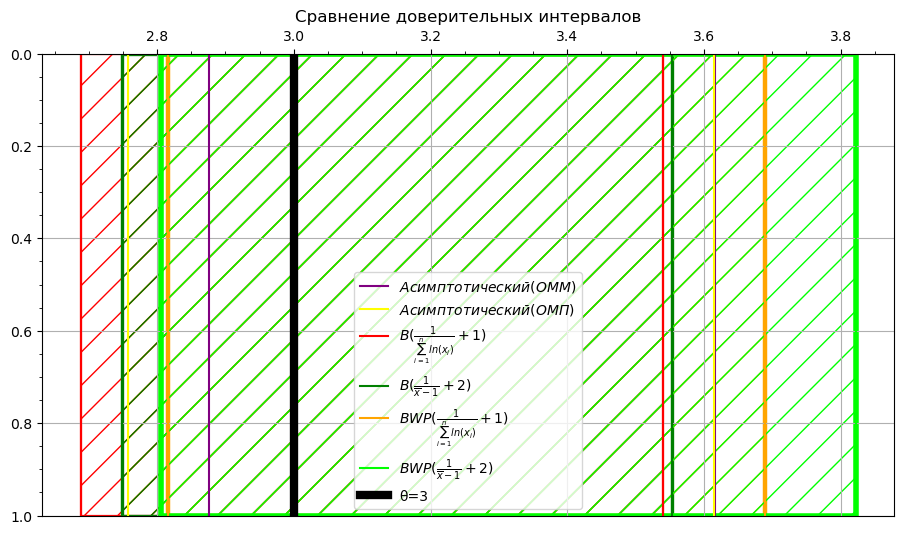

In [14]:
fig, ax = plt.subplots(figsize=(11, 6))

y_min, y_max = 0, 1

plt.title('Сравнение доверительных интервалов')
plt.ylim(y_min, y_max)
ax.minorticks_on()
ax.grid(which='major')

colors = ['purple', 'yellow', 'red', 'green', 'orange', 'lime']
n_est_formula = [r'\frac{1}{\sum_{i=1}^{n}ln(x_i)}+1', r'\frac{1}{\overline{x}-1}+2']
labels = ['Асимптотический(OMM)', 'Асимптотический(OMП)'] + [f'B({formula})' for formula in n_est_formula] + [f'BWP({formula})' for formula in n_est_formula] 
labels += [f'θ={t}']
min_width, max_width = 0, 4
linewidths = np.linspace(min_width, max_width, len(intervals))

y = [y_min, y_max]

for i, interv in enumerate(intervals):
    xi1 = [interv[0], interv[0]]
    xi2 = [interv[1], interv[1]]
    ax.plot(xi1, y, color=colors[i], label=fr'${labels[i]}$')
    ax.plot(xi2, y, color=colors[i])
    patch = patches.Rectangle((xi1[0], y[0]), xi2[0]-xi1[0], y[1], linewidth=linewidths[i], fill=None, hatch='/', color=colors[i])
    ax.add_patch(patch)

ax.plot((t, t), y, color='black', label=labels[-1], linewidth=max_width*1.5)

plt.gca().invert_yaxis()
plt.gca().axes.xaxis.set_ticks_position("top")
plt.legend()

fig1 = plt.gcf()
plt.show()